# Fire Hazard Incidents Analytics Pipeline
## Civilian Severity vs Time taken to control Fire

## Importing Required Libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

from storedb import save_in_db, IMG_PATH

## Creating Spark Session and using all available cores

In [2]:
%%time
spark = SparkSession \
    .builder \
    .appName("532: Project") \
    .config("local[4]") \
    .getOrCreate()

22/12/11 20:39:11 WARN Utils: Your hostname, Janhvis-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.1.109 instead (on interface en0)
22/12/11 20:39:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/11 20:39:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/12/11 20:39:12 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/12/11 20:39:12 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
CPU times: user 19.8 ms, sys: 21.4 ms, total: 41.2 ms
Wall time: 2.4 s


## Loading civilian casuality and basic module data

In [3]:
%%time
civilian_casualities_df = spark.read.options(delimiter="^", header=True).csv("civiliancasualty.txt")
basic_module_df = spark.read.options(delimiter="^", header=True).csv("basicincident.txt")

CPU times: user 3.54 ms, sys: 2.71 ms, total: 6.24 ms
Wall time: 2.8 s


In [4]:
%%time
# Formatting datetime columns
basic_time_module_df = basic_module_df.withColumn("ALARM_TIME", F.to_timestamp("ALARM","MMddyyyyHHmm")).withColumn("CONT_TIME", F.to_timestamp("INC_CONT","MMddyyyyHHmm")).withColumn("ARV_TIME", F.to_timestamp("ARRIVAL","MMddyyyyHHmm"))

CPU times: user 3.15 ms, sys: 1.92 ms, total: 5.06 ms
Wall time: 81 ms


In [5]:
%%time
# Finding Civilian Casualty vs. Total Fire Time(in seconds)
total_fire_time_df = basic_time_module_df.withColumn("TOTAL_FIRE_TIME", basic_time_module_df.CONT_TIME.cast("long") - basic_time_module_df.ALARM_TIME.cast("long"))
civilian_casualty_fire_time = total_fire_time_df.join(civilian_casualities_df, total_fire_time_df.INCIDENT_KEY == civilian_casualities_df.INCIDENT_KEY)
ccft_df = civilian_casualty_fire_time.groupBy("SEV").agg(F.avg("TOTAL_FIRE_TIME").alias("AVG_FIRE_TIME"))
p_ccft_df = ccft_df.toPandas()
p_ccft_df["AVG_FIRE_TIME"] = p_ccft_df["AVG_FIRE_TIME"]/60

CPU times: user 264 ms, sys: 77.9 ms, total: 341 ms
Wall time: 3.8 s


CPU times: user 72.3 ms, sys: 8.36 ms, total: 80.7 ms
Wall time: 82.1 ms


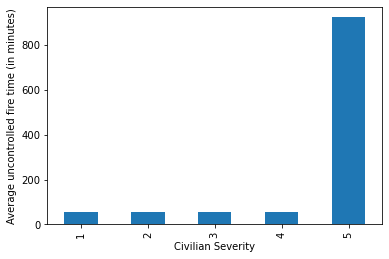

In [7]:
%%time
p3 = p_ccft_df.drop([2]).sort_values(by="SEV").plot(x="SEV", y="AVG_FIRE_TIME", xlabel="Civilian Severity", ylabel = "Average uncontrolled fire time (in minutes)", kind="bar", legend = False)
fig3 = p3.get_figure()
fig_name = "civ_fire_time.png"
fig3.savefig(f"{IMG_PATH}{fig_name}")

# saving to db
save_in_db(fig_name, "civilian_severity_vs_fire_time")